In [1]:
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from xfoil import XFoil
from xfoil.model import Airfoil
from scipy.interpolate import CubicSpline
from scipy.special import comb
from deap import base, creator, tools, algorithms
from xfoil.test import naca0012
n_iter = 100  # Number of iterations of the bayesian 
init_size = 150
save = False
# Define the airfoil function
n_ctr_pts = 10
angle_attack = 10
n_times = 120
init_size = 150
max_iterations= 100
n_restarts = 25
# Genetic Algorithm parameters
population_size = 100
max_generations = 200
mach = 0.15
re = 1e6
std_x = [naca0012.x[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [1]
std_y = [naca0012.y[i] for i in range(0, naca0012.x.shape[0], naca0012.x.shape[0] // (n_ctr_pts * 2))][:-1] + [0]


In [3]:


def normalize_airfoil(points):
    # Extract x-coordinates and y-coordinates
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    
    # Find the leading edge (min x-coordinate) and trailing edge (max x-coordinate)
    x_min = np.min(x_coords)
    x_max = np.max(x_coords)
    
    # Calculate the chord length
    chord_length = x_max - x_min
    
    # Normalize x-coordinates to make the chord length equal to 1
    normalized_x_coords = (x_coords - x_min) / chord_length
    
    # Combine normalized x-coordinates and original y-coordinates
    normalized_points = np.array(list(zip(normalized_x_coords, y_coords)))
    
    return normalized_points
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def airfoil(h, n_ctr_pts=n_ctr_pts, chord=naca0012.x, nTimes=n_times):
    top_half = [(x, y) for x, y in zip(chord[:n_ctr_pts], h[0])] 
    low_half = [(x, -y) for x, y in zip(chord[n_ctr_pts:], h[1])]
    pts =  top_half +  low_half  # Include leading and trailing edges
    pts = np.array(pts)
    x = np.append(pts[:, 0][:-1], pts[:, 0][0])
    y = np.append(pts[:, 1][:-1], pts[:, 1][0])
    t = np.linspace(0.0, 1, nTimes)
    polynomial_array = np.array([ bernstein_poly(i, n_ctr_pts*2-1, t) for i in range(0, n_ctr_pts*2)   ])
    xvals = np.dot(x, polynomial_array)
    yvals = np.dot(y, polynomial_array)
    pts = np.column_stack([xvals, yvals])
    pts = normalize_airfoil(pts)
    #plot_foil(pts)
    """plt.figure(figsize=(10, 5))
    plt.scatter(x[0], y[0],  color='r', marker='o')
    plt.scatter(x[-1], y[-1])
    plt.plot(x,y)
    plt.plot(xvals, yvals)
    plt.grid(True)"""
    return pts, Airfoil(x=pts[:, 0], y=pts[:, 1])


def plot_foil(pts, fit, lift_im, drag_im, std_points=[naca0012.x, naca0012.y], save=True):
    # Extract x and y coordinates for plotting
    x, y = pts[:, 0], pts[:, 1]
    # Plot the airfoil shape
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, label='Airfoil Shape', color='b', marker='o')
    plt.fill(x, y, 'b', alpha=0.3)  # Fill the shape for better visualization
    plt.plot(std_points[0], std_points[1], label='NACA0012', color='r', marker='o')
    plt.fill(std_points[0], std_points[1], 'r', alpha=0.3)
    # Adding labels and legend
    plt.xlabel('Chord Position')
    plt.ylabel('Height')
    plt.title('Airfoil Shape')
    plt.legend()
    plt.text(0.78, -0.15, f'lift improvment {lift_im:.2f}%\ndrag improvment {drag_im:.2f}%', fontsize=10)
    plt.text(0, -0.15, f'C_lift {fit[0]:.3f}, C_drag {fit[1]:.3f}', fontsize=10)

    #plt.grid(True)
    plt.axis('equal')
    if save:
        plt.savefig(f"bayes\yes_lift_{lift_im:.2f}_drag_{drag_im:.2f}.pdf")
    plt.show()

In [4]:
def fitness(air):
    xf = XFoil()
    xf.airfoil = air
    xf.Re = re
    xf.mach = mach
    xf.max_iter = 100
    cl, cd, cm, cp = xf.a(angle_attack)
    return cl, cd

In [5]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil(individual):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis

    cl, cd, cm, cp = xf.a(angle_attack)
    if math.isnan(cl) or math.isnan(cd):
        return 0, 10e5
    else:
        # Return Cl and Cd
        return cl, cd


In [6]:
# Function to evaluate fitness (maximize Cl, minimize Cd)
def evaluate_airfoil_angle_attacks(individual, min=-20, max=20, step=1):
    # Decode individual (genotype) into airfoil parameters
    h = np.array([individual[:n_ctr_pts], np.abs(individual[n_ctr_pts:])])
    
    # Generate airfoil shape
    pts, foil = airfoil(h, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)
    
    # Use XFoil to evaluate Cl and Cd
    xf = XFoil()
    xf.airfoil = foil
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)

    # Return Cl and -Cd (minimize Cd -> maximize -Cd)
    return a, cl, cd


In [7]:
def naca_eval(min=-20, max=20, step=1):
    xf = XFoil()
    xf.airfoil = naca0012
    xf.Re = re
    xf.mach = mach
    xf.max_iter = max_iterations
    # Run XFoil analysis
    a, cl, cd, cm, cp = xf.aseq(min, max, step)
    return a, cl, cd

In [8]:


# GPModel class for Gaussian Process Regression
class GPModel:
    def __init__(self, kernel=None):
        if kernel is None:
            kernel = Matern(nu=2.5)
        self.gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def fit(self, X, y):
        self.gp.fit(X, y)

    def predict(self, X):
        return self.gp.predict(X, return_std=True)

# Acquisition function for multi-objective optimization
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X)
    mu_sample = gpr.predict(X_sample)

    mu_sample_opt = np.max(Y_sample)  # Optimal value in Y_sample for each objective

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.flatten()

# Propose location for next evaluation
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(1, -1), X_sample, Y_sample, gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(1, -1)
# Multi-objective Bayesian Optimization


# Define the bounds of the search space (0 to 0.1 for each element in h)
bounds = np.array([[0, 0.2]] * (n_ctr_pts * 2))
#X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(init_size, bounds.shape[0]))
# Create initial population (using NACA0012 as baseline)
initial_population = []
for _ in range(init_size):
    perturbation = np.random.normal(0, 0.02, size=n_ctr_pts * 2)
    individual = np.concatenate((std_y[:n_ctr_pts], np.abs(std_y[n_ctr_pts:]))) + perturbation
    initial_population.append(individual)
X_sample = np.array(initial_population)
Y_sample = np.array([evaluate_airfoil(ind) for ind in X_sample])

gp_cl = GPModel()
gp_cd = GPModel()
gp_cl.fit(X_sample, Y_sample[:, 0].reshape(-1, 1))
gp_cd.fit(X_sample, Y_sample[:, 1].reshape(-1, 1))

for i in range(n_iter):
    X_next = propose_location(expected_improvement, X_sample, Y_sample[:, 0], gp_cl, bounds, n_restarts)
    Y_next = evaluate_airfoil(X_next.flatten())
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    gp_cl.fit(X_sample, Y_sample[:, 0].reshape(-1, 1))
    gp_cd.fit(X_sample, Y_sample[:, 1].reshape(-1, 1))

    print(f"Iteration {i+1}: Cl - {Y_sample[:, 0].max()}, Cd - {Y_sample[:, 1].min()}")




Iteration 1: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 2: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 3: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 4: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 5: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 6: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 7: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 8: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 9: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 10: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 11: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 12: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 13: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 14: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 15: Cl - 1.2688584327697754, Cd - 0.011145117692649364
Iteration 16: Cl - 1.2688584327697

In [38]:
if save:
    # Directory to save the data
    save_dir = 'pop_bayes/'

    # Ensure the directory exists or create it
    os.makedirs(save_dir, exist_ok=True)

    # Save X_sample and Y_sample
    np.save(os.path.join(save_dir, 'X_sample.npy'), X_sample)
    np.save(os.path.join(save_dir, 'Y_sample.npy'), Y_sample)

    print("Arrays saved successfully.")

Arrays saved successfully.


In [8]:
# Directory where the data is saved
load_dir = 'pop_bayes/'

# Load X_sample and Y_sample
X_sample = np.load(os.path.join(load_dir, 'X_sample.npy'))
Y_sample = np.load(os.path.join(load_dir, 'Y_sample.npy'))

print("Arrays loaded successfully.")

Arrays loaded successfully.


In [9]:
def is_dominated(point, others):
    for other in others:
        if (other[0] > point[0] and other[1] < point[1]) or (other[0] >= point[0] and other[1] <= point[1] and not np.array_equal(point, other)):
            return True
    return False

def pareto_front_with_indexes(points):
    pareto_points = []
    pareto_indexes = []
    for index, point in enumerate(points):
        if not is_dominated(point, np.delete(points, index, axis=0)):
            pareto_points.append(point)
            pareto_indexes.append(index)
    return np.array(pareto_points), np.array(pareto_indexes)
pareto_points, pareto_indexes = pareto_front_with_indexes(Y_sample)
print("Pareto front points:")
print(pareto_points)

Pareto front points:
[[0.65149474 0.01114512]
 [1.46644819 0.01281307]
 [1.44175613 0.01216117]
 [1.49041474 0.01309156]
 [1.44333649 0.01250655]
 [1.4740299  0.01292549]
 [1.44066644 0.0119557 ]
 [1.44574106 0.01265991]
 [1.51820874 0.01323855]]


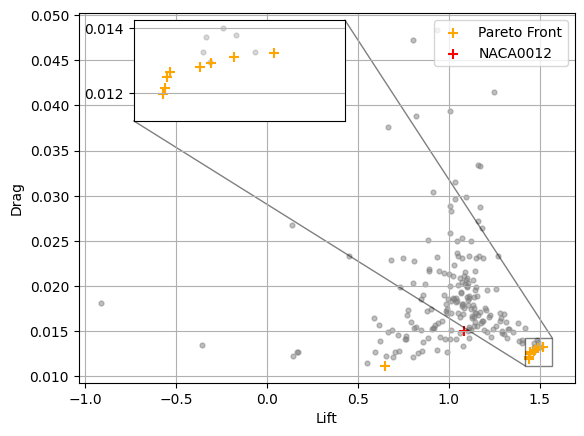

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch
# Combine the lists into a list of points
points = []
for i in Y_sample:
    if i[1] != 10e5:
        points.append(i)

# Find the Pareto front
pareto = pareto_points

# Separate the Pareto front points
pareto_l = [p[0] for p in pareto]
pareto_d = [p[1] for p in pareto]

# Remove Pareto front points from lifts and drags
remaining_points = [p for p in points if p not in pareto]
remaining_l = [p[0] for p in remaining_points]
remaining_d = [p[1] for p in remaining_points]


# Create the main plot
fig, ax = plt.subplots()
ax.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.5)
ax.scatter(pareto_l, pareto_d, color="orange", marker='+', s=60, label="Pareto Front")
naca0012_fit = np.array(fitness(naca0012))
ax.scatter(naca0012_fit[0], naca0012_fit[1], color="red", marker='+', s=60, label="NACA0012")
# Define the zoomed area (replace with1 your specific coordinates)
zoom_x1, zoom_x2 = 1.42, max(pareto_l) +0.05
zoom_y1, zoom_y2 = min(pareto_d), max(pareto_d) +0.001

# Add a rectangle to highlight the zoomed area
rect = plt.Rectangle((zoom_x1, zoom_y1), zoom_x2 - zoom_x1, zoom_y2 - zoom_y1, 
                     edgecolor='black', facecolor='none', linestyle='-', alpha=0.5)
ax.add_patch(rect)

# Create an inset plot
axins = inset_axes(ax, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.2, 0.18, 1.1, .7),
                   bbox_transform=ax.figure.transFigure)

# Plot the same data on the inset
axins.scatter(remaining_l, remaining_d, color="grey", s=12, alpha=0.3)
axins.scatter(pareto_l, pareto_d, color="orange", marker='+', s=60)

# Set the limits of the inset plot to match the zoomed area
axins.set_xlim(zoom_x1, zoom_x2)
axins.set_ylim(zoom_y1, zoom_y2)
axins.grid(True)

# Hide x-axis labels of the inset plot to avoid overlapping
axins.xaxis.set_visible(False)

# Add lines connecting the rectangle to the inset plot
for side in [(zoom_x1, zoom_y1),(zoom_x2, zoom_y2)]:
    con = ConnectionPatch(xyA=side, coordsA=ax.transData,
                          xyB=side, coordsB=axins.transData,
                          color='black', linestyle='-', linewidth=1, alpha = 0.5)
    ax.add_artist(con)

ax.set_xlabel("Lift")
ax.set_ylabel("Drag")
ax.legend(loc='upper right')
ax.grid(True)

plt.savefig("bayes_pareto.pdf")
plt.show()

In [11]:
import pygmo as pg

def compute_hypervolume(lifts, drags, reference_point):
    # Combine lifts and drags into a list of points
    points = list(zip(lifts, drags))
    
    # Create a hypervolume object
    hv = pg.hypervolume(points)
    
    # Compute the hypervolume with respect to the reference point
    volume = hv.compute(reference_point)
    
    return volume
# Define a reference point that dominates all points in your list
reference_point = [2.6, 0.26]

hypervolume = compute_hypervolume(pareto_l, pareto_d, reference_point)
print(f"The hypervolume is: {hypervolume}")

The hypervolume is: 0.4848950467942476


## Pareto front results

In [12]:
import numpy as np


# Normalize the objectives
lift_values = np.abs(pareto_points[:, 0])
drag_values = np.abs(pareto_points[:, 1])

norm_lift = (lift_values - lift_values.min()) / (lift_values.max() - lift_values.min())
norm_drag = (drag_values - drag_values.min()) / (drag_values.max() - drag_values.min())

# Compute the distances to the ideal point (1, 0)
ideal_point = np.array([1, 0])
distances = np.sqrt((1 - norm_lift)**2 + norm_drag**2)

# Find the elbow point
elbow_index = np.argmin(distances)
elbow_point = pareto_points[elbow_index]

print(f"Elbow point (best trade-off): Lift = {elbow_point[0]}, Drag = {elbow_point[1]}")
print(elbow_point[0]/elbow_point[1])


Elbow point (best trade-off): Lift = 1.4406664371490479, Drag = 0.011955702677369118
120.50035669388778


#### Section 1
ploting the Airfoils that give a better drag and lift compared to the NACA0012
#### Section 2
plotting all the pareto front individuals

## Section 1

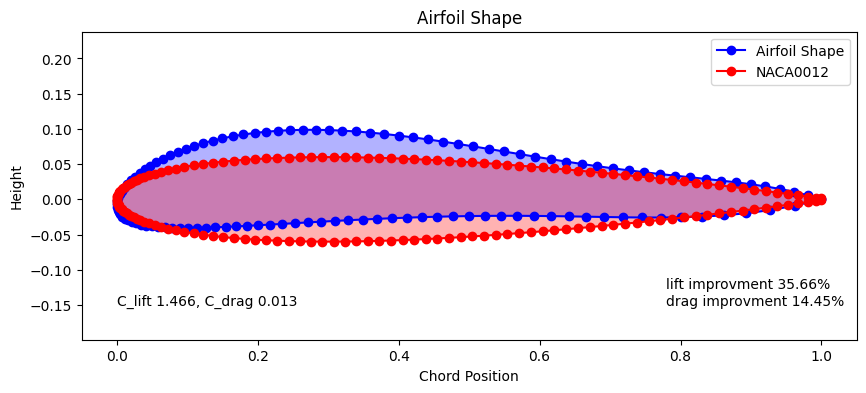

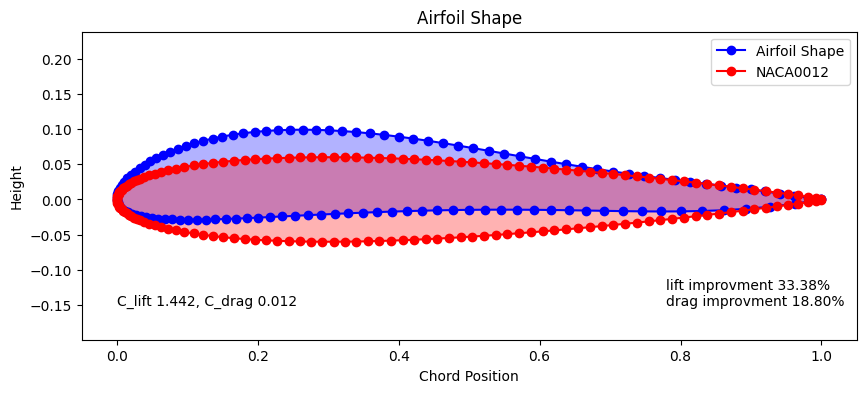

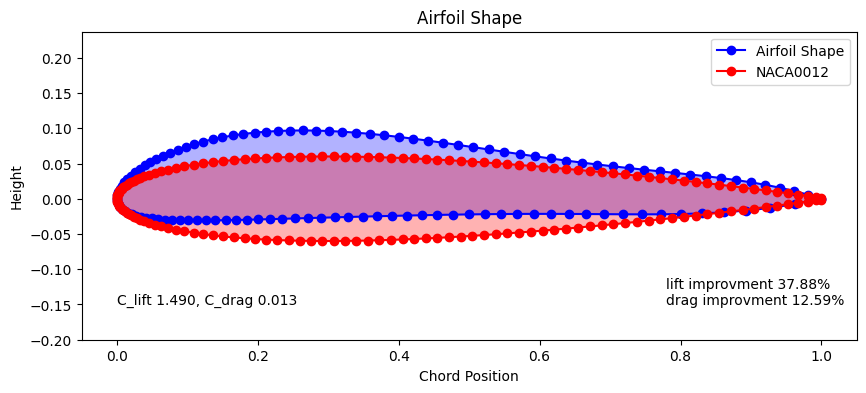

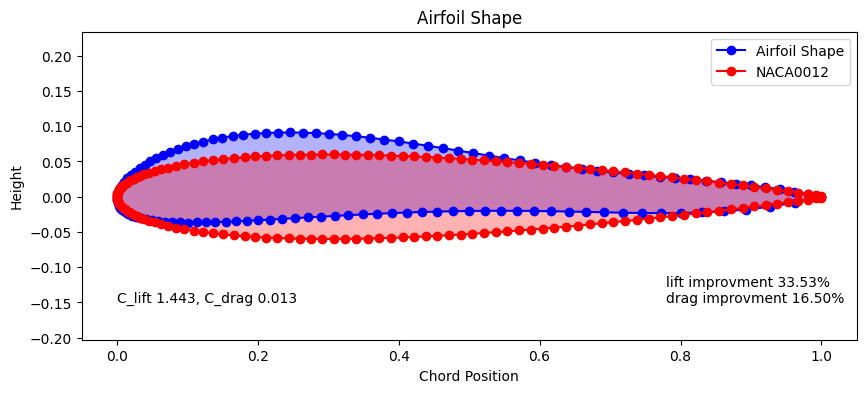

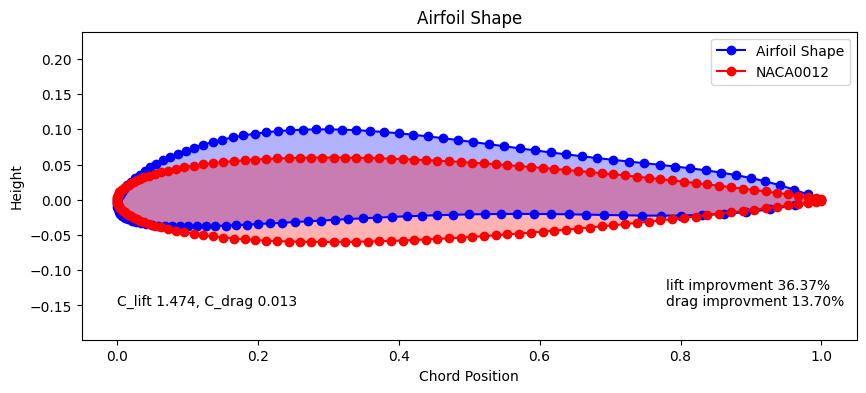

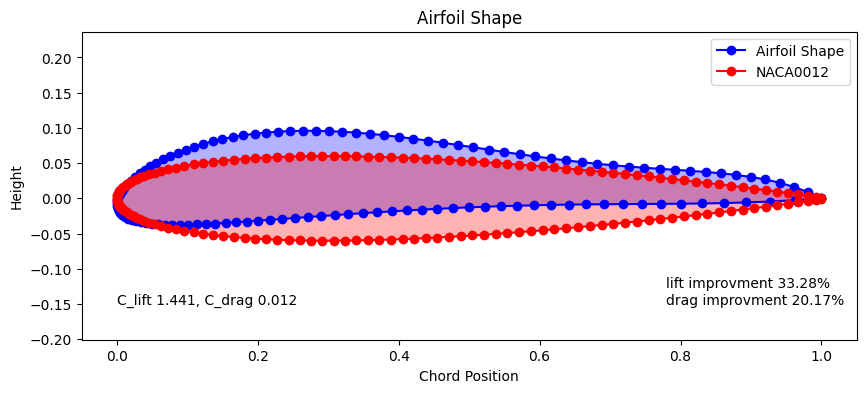

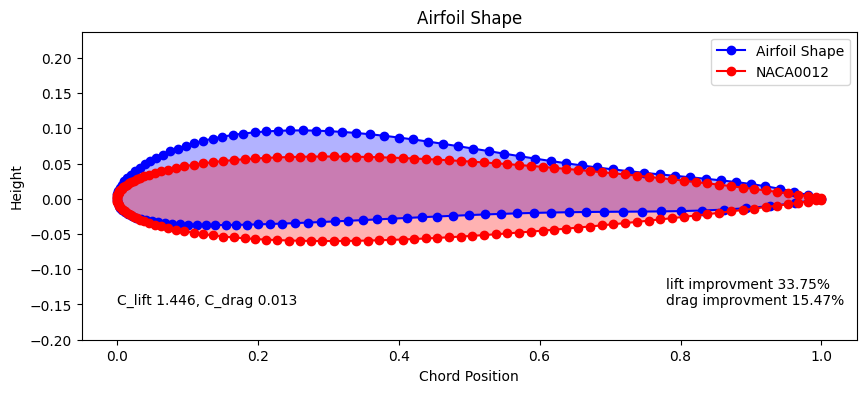

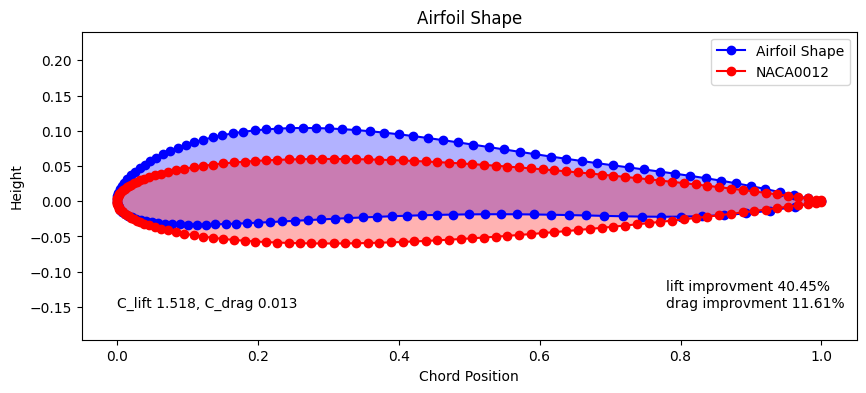

In [15]:
naca_a, naca_cl, naca_cd = naca_eval()

for i in pareto_indexes:
    if Y_sample[i][0] != 0 and Y_sample[i][1] != -1e5:
        ind = X_sample[i]
        fit = Y_sample[i]
        best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
        best, foil = airfoil(best_indiv, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)

        direction = fit[0] / abs(fit[0])
        naca0012_fit = np.array(fitness(naca0012))

        lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
        drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100

        if lift_improvement > 0 and drag_improvement > 0:
            plot_foil(best, fit, lift_improvement, drag_improvement)



## Section 2

In [43]:
naca_a, naca_cl, naca_cd = naca_eval()
lift_p = []
drag_p = []
for i in pareto_indexes:
    if Y_sample[i][0] != 0 and Y_sample[i][1] != -1e5:
        ind = X_sample[i]
        fit = Y_sample[i]
        lift_p.append(abs(fit[0]))
        drag_p.append(abs(fit[1]))
        best_indiv = np.array([ind[:n_ctr_pts], np.abs(ind[n_ctr_pts:])])
        best, foil = airfoil(best_indiv, n_ctr_pts=n_ctr_pts, chord=std_x, nTimes=n_times)

        direction = fit[0] / abs(fit[0])
        naca0012_fit = np.array(fitness(naca0012))
        
        lift_improvement = ((np.abs(fit[0]) - naca0012_fit[0]) / naca0012_fit[0]) * 100
        drag_improvement = ((naca0012_fit[1] - np.abs(fit[1])) / naca0012_fit[1]) * 100
print(np.mean(lift_p), np.mean(drag_p))
print(max(lift_p), min(drag_p))

print(naca0012_fit)

1.3746773799260457 0.012499680225219991
1.5182087421417236 0.011145117692649364
[1.08094001 0.01497712]
